In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
start = time.time()

Using TensorFlow backend.


In [2]:
# # uncomment to disable GPU
# #import os
# #os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# import tensorflow as tf
# # reduce memory usage, in case you're
# # on a machine with 1 GPU
# print (tf.test.gpu_device_name())
# gpus = tf.config.experimental.list_physical_devices('GPU')
# configs = tf.config.get_logical_device_configuration(gpus[0])
# print (configs)
# if gpus:
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)

In [3]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Reference Model

In [4]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
population_fraction = population/np.sum(population)
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)
# Getting the time length
time_S = np.unique(results['time'].values)
Time_S = len(time_S)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, Time_S, M, C))
start_time = 30
end_time = 75
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
        
start_time = 30
end_time = 70        
Time = end_time - start_time
p = 0
ref_traj = ref_traj[:,start_time:end_time,:,:]
ref_traj[p,:,:,4] +=  ref_traj[p,:,:,5] + ref_traj[p,:,:,6]
ref_traj = ref_traj[p,:,:,:5]
# REF=ref_traj

## Combining P and D compartments into R
ref_traj = ref_traj[np.newaxis,:,:,:]
print (np.shape(ref_traj))


(1, 40, 62, 5)


Plotting 62 patches in a 7 x 9 grid


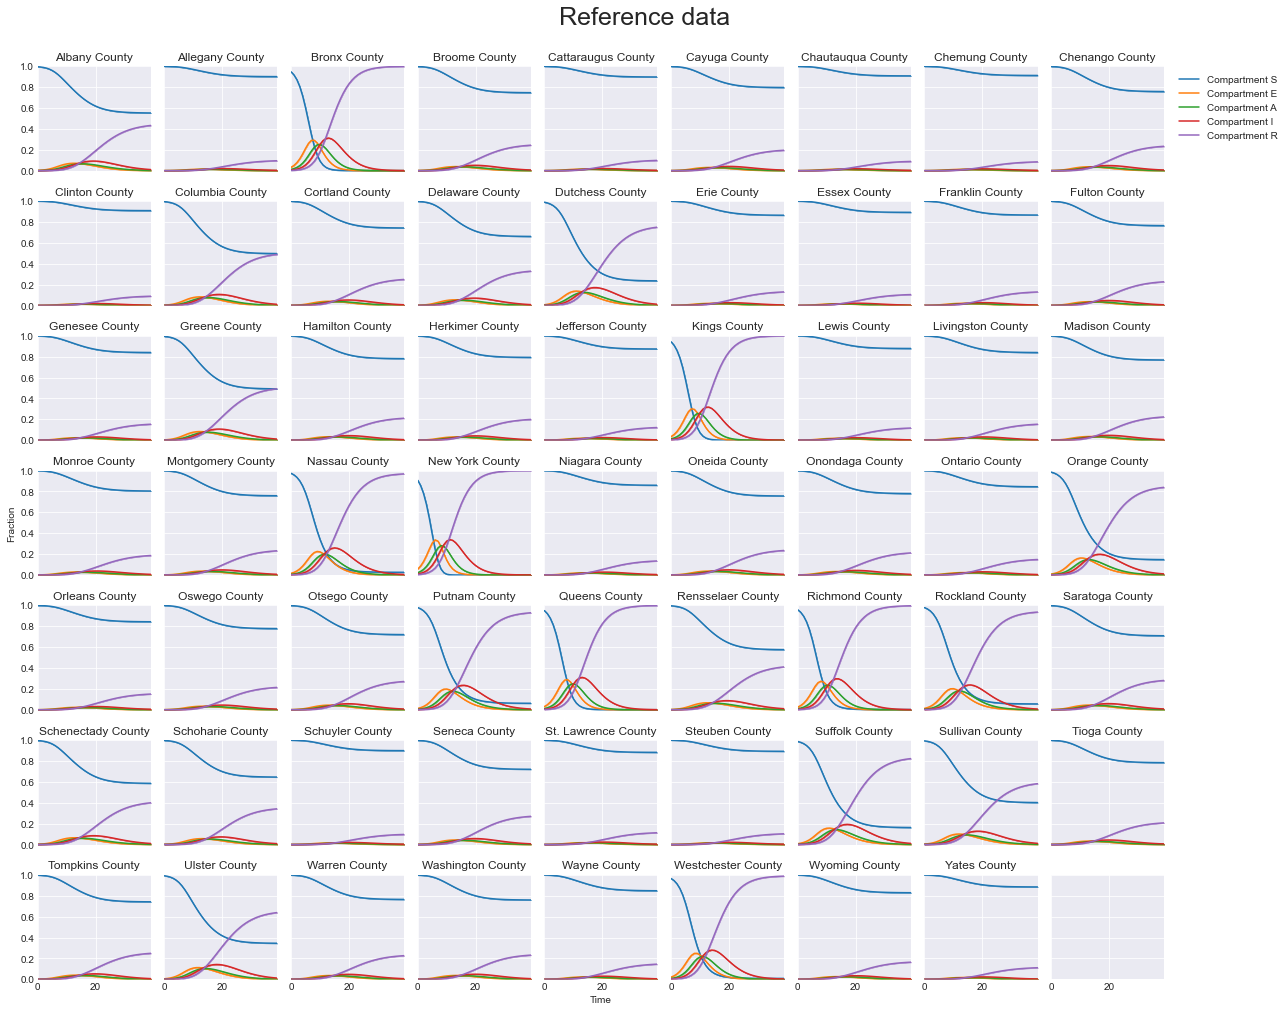

In [5]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
plt.suptitle("Reference data", size=25, y=1.001)
plt.tight_layout()
plt.savefig('patch_quantile.png',dpi=400)
plt.show()

In [6]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

In [7]:
# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()
print (ref_traj.shape)

(1, 40, 62, 5)


In [8]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
networkCounty = networkCounty[['ID','mobility_parameter']]
Mobility_martix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'ID']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'ID'] == 0:
            Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
            mobility_parameter_row = np.zeros(M)
    else:
         Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
assert (np.shape(Mobility_martix)==(M,M))
Mobility_martix_norm = Mobility_martix / np.sum(Mobility_martix, axis=1).reshape(M,1)
print (Mobility_martix_norm.shape)

(62, 62)


## Restraining a sample SEAIRPD to reference

In [9]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 4)
#tmat.add_transition('I', 'P', 5, 2)
#tmat.add_transition('P', 'D', 5, 2)
#tmat.add_transition('D', 'R', 5, 2)

print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = 0.0001
hyper_pram.beta_high = 0.5
hyper_pram.beta_var = 0.1
hyper_pram.start_high = 0.01
# hyper_pram.start_var = 0.1
# hyper_pram.R_var = 0.001
hyper_pram.beta_start = 0.1
hyper_pram.start_mean = 0.001
# hyper_pram.start_scale = 0.1

start_logits = np.zeros((M,))
start_logits[:]=np.log(0.01)
param_model = maxentep.MetaParameterJoint(start_logits, Mobility_martix_norm , tmat, name='unbiased_model',hypers = hyper_pram )

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [10]:
import tqdm
N = 256
batches = 4
outs = []
infect = maxentep.contact_infection_func(infections_compartments,area = area)
model = maxentep.MetaModel(infect, Time,populations = np.round(population))
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# trajs = trajs[:,start_time:end_time,:,:]
print(trajs.shape)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.75s/it]

(1024, 40, 62, 5)


## Make restraints from reference trajectory

A I R
10 0.02173425899807039 0.02173425899807039
3 0.002884055777929942 0.002884055777929942
31 0.007486204369364554 0.007486204369364554
17 0.03360430478746704 0.03360430478746704
24 0.02103483799980968 0.02103483799980968
10 0.016843936148894966 0.016843936148894966
17 0.04445733361323688 0.04445733361323688
31 0.022374865132314424 0.022374865132314424
3 0.0014144395679897982 0.0014144395679897982
24 0.04271176457822342 0.04271176457822342
31 0.2052956921971256 0.2052956921971256
3 0.0006080492624151891 0.0006080492624151891
17 0.06336591198563982 0.06336591198563982
10 0.011040064308516317 0.011040064308516317
24 0.14510438174186285 0.14510438174186285
24 0.011946034225737923 0.011946034225737923
10 0.011577753197053337 0.011577753197053337
17 0.018335965524143554 0.018335965524143554
31 0.004351419276385796 0.004351419276385796
3 0.0015303710479133061 0.0015303710479133061
10 0.00895466297695562 0.00895466297695562
24 0.023725128437193738 0.023725128437193738
31 0.01277029210030324

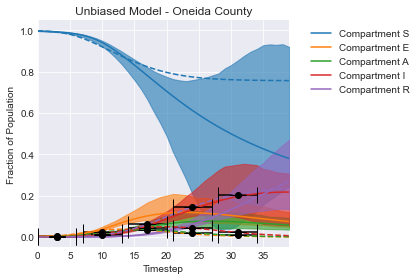

['S', 'E', 'A', 'I', 'R']


In [11]:
full_compartments = ['S'] + compartments
npoints = 5
prior = maxentep.EmptyPrior()
# p = 0

# restrained_patches = np.random.randint(M, size=number_of_restraint_patches)
number_of_restrained_patches = 10 
restrained_compartments = [2,3,4] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
print (restrained_compartments_names)
number_of_restrained_compartments = len(restrained_compartments) 

restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)

restrained_patch = restrained_patches[0]
def compartment_restrainer(number_of_restrained_patches,number_of_restrained_compartments,npoints,ref_traj,prior,noise=0,time_average=7):
    assert number_of_restrained_patches <= M, 'Number of patches to be restrained exceeeds the total number of patches'
#     p = 0  # picking one trajectory from the parameter set (pick the first 1)
    # example if number_of_restraint_patches = 2 : (recovered and infected patch)
    restraints =[] 
    plot_fxns_list = []
    for i in range(number_of_restrained_patches):
        plot_fxns = []
        for j in range(number_of_restrained_compartments):
            res, plfxn = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patches[i],restrained_compartments[j]], npoints, prior, noise,time_average)
            restraints += res 
            plot_fxns += plfxn
        plot_fxns_list.append(plot_fxns)
    return restraints, plot_fxns_list


restraints, plot_fxns_list = compartment_restrainer(number_of_restrained_patches,number_of_restrained_compartments,npoints,ref_traj,prior)
maxentep.traj_quantile(trajs[:,:,restrained_patch,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,restrained_patch,:], linestyle='--')
plt.title('Unbiased Model - {}'.format(patches[restrained_patch]))
for i,pf in enumerate(plot_fxns_list[0]):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.show()
print (full_compartments)

In [12]:

print (restrained_compartments_names)
# npoints =4
# prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
# restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,4], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
# restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
# restraints = restraints_I + restraints_R
# plot_fxns = plot_fxn_I + plot_fxn_R


A I R


In [13]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [14]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [15]:
me_history = me_model.fit(trajs, batch_size=64,epochs=1000)#, callbacks=[CustomCallback()])

Epoch 1/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0157 - weight-entropy: 3.7254
Epoch 2/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0157 - weight-entropy: 3.9175
Epoch 3/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0141 - weight-entropy: 4.0485
Epoch 4/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0142 - weight-entropy: 3.4695
Epoch 5/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.6003
Epoch 6/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0136 - weight-entropy: 3.5993
Epoch 7/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0161 - weight-entropy: 3.2781
Epoch 8/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0139 - weight-entropy: 3.2677
Epoch 9/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0162 - weight-entropy: 3.0994
Epoch 10/1000
16/16 [=========================

16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.5971
Epoch 78/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 1.6457
Epoch 79/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 1.9923
Epoch 80/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.8518
Epoch 81/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0135 - weight-entropy: 2.1081
Epoch 82/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 1.9331
Epoch 83/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0142 - weight-entropy: 2.4070
Epoch 84/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.6721
Epoch 85/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.8599
Epoch 86/1000
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 0.0147 - weight-entropy: 2.0444
Epoch 154/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0152 - weight-entropy: 2.3957
Epoch 155/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0140 - weight-entropy: 1.8163
Epoch 156/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0144 - weight-entropy: 2.1395
Epoch 157/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0139 - weight-entropy: 2.0106
Epoch 158/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.7265
Epoch 159/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0137 - weight-entropy: 1.8816
Epoch 160/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0139 - weight-entropy: 1.5560
Epoch 161/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 1.7469
Epoch 162/1000
16/16 [=====================

Epoch 229/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 1.5669
Epoch 230/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 2.1591
Epoch 231/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0153 - weight-entropy: 0.9489
Epoch 232/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 1.7224
Epoch 233/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0142 - weight-entropy: 1.7183
Epoch 234/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0149 - weight-entropy: 1.9704
Epoch 235/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0137 - weight-entropy: 1.6040
Epoch 236/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0144 - weight-entropy: 2.0022
Epoch 237/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 1.4284
Epoch 238/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.5887
Epoch 305/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 1.9177
Epoch 306/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 1.4893
Epoch 307/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0129 - weight-entropy: 1.1378
Epoch 308/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0147 - weight-entropy: 1.3916
Epoch 309/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 2.0835
Epoch 310/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0131 - weight-entropy: 1.4744
Epoch 311/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 1.5212
Epoch 312/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 1.6613
Epoch 313/1000
16/16 [=====================

16/16 [==============================] - 0s 1ms/step - loss: 0.0137 - weight-entropy: 1.4958
Epoch 381/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0137 - weight-entropy: 1.2311
Epoch 382/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.2529
Epoch 383/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.2260
Epoch 384/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.2097
Epoch 385/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.2488
Epoch 386/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0141 - weight-entropy: 1.7549
Epoch 387/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 1.5448
Epoch 388/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 1.4082
Epoch 389/1000
16/16 [=====================

16/16 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 0.9757
Epoch 457/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0144 - weight-entropy: 1.6534
Epoch 458/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.2858
Epoch 459/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0137 - weight-entropy: 1.6909
Epoch 460/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 1.4506
Epoch 461/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.2775
Epoch 462/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0131 - weight-entropy: 1.3244
Epoch 463/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.4468
Epoch 464/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 0.8123
Epoch 465/1000
16/16 [=====================

Epoch 532/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 1.1076
Epoch 533/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 1.4784
Epoch 534/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.8107
Epoch 535/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 1.5872
Epoch 536/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.6706
Epoch 537/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0131 - weight-entropy: 1.8591
Epoch 538/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.4478
Epoch 539/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0137 - weight-entropy: 1.6475
Epoch 540/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.4004
Epoch 541/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 1.4601
Epoch 608/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0136 - weight-entropy: 1.3735
Epoch 609/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 1.5715
Epoch 610/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.4486
Epoch 611/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0136 - weight-entropy: 1.4676
Epoch 612/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0138 - weight-entropy: 1.5016
Epoch 613/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0139 - weight-entropy: 1.7833
Epoch 614/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.1244
Epoch 615/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0142 - weight-entropy: 1.5026
Epoch 616/1000
16/16 [=====================

16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.0933
Epoch 684/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.3288
Epoch 685/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0131 - weight-entropy: 1.2531
Epoch 686/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.2988
Epoch 687/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 1.0754
Epoch 688/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0137 - weight-entropy: 1.2413
Epoch 689/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.1184
Epoch 690/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.0823
Epoch 691/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0129 - weight-entropy: 1.3134
Epoch 692/1000
16/16 [=====================

Epoch 759/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.7776
Epoch 760/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0129 - weight-entropy: 1.1894
Epoch 761/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 1.4847
Epoch 762/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0129 - weight-entropy: 1.5087
Epoch 763/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.8297
Epoch 764/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.5439
Epoch 765/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0131 - weight-entropy: 1.7259
Epoch 766/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 1.9248
Epoch 767/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 1.3667
Epoch 768/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0129 - weight-entropy: 1.3819
Epoch 835/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.3947
Epoch 836/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0129 - weight-entropy: 1.2443
Epoch 837/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 1.9072
Epoch 838/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.6557
Epoch 839/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 1.3897
Epoch 840/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.8035
Epoch 841/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 1.8666
Epoch 842/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.5878
Epoch 843/1000
16/16 [=====================

Epoch 910/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.2482
Epoch 911/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0129 - weight-entropy: 1.8610
Epoch 912/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0129 - weight-entropy: 1.1040
Epoch 913/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 0.9219
Epoch 914/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0129 - weight-entropy: 1.4156
Epoch 915/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0131 - weight-entropy: 1.4648
Epoch 916/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 1.5563
Epoch 917/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.2520
Epoch 918/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0129 - weight-entropy: 1.0656
Epoch 919/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.0887
Epoch 986/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.3593
Epoch 987/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.3709
Epoch 988/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 0.9153
Epoch 989/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 1.1620
Epoch 990/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0135 - weight-entropy: 1.6627
Epoch 991/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0134 - weight-entropy: 1.6081
Epoch 992/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 1.0773
Epoch 993/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 1.3797
Epoch 994/1000
16/16 [=====================

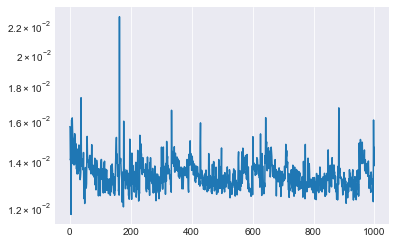

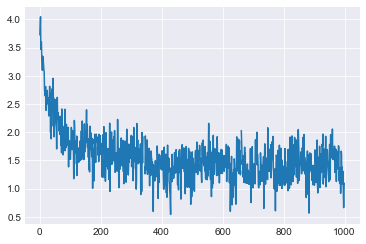

In [16]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.show()



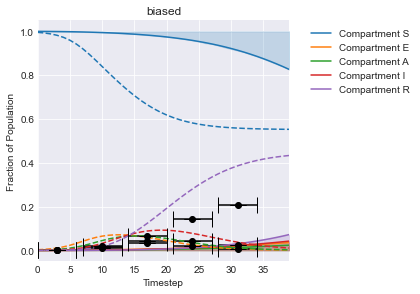

In [17]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights,alpha=0.2, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, me_model.lambdas[i], color='k')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('biased')
plt.show()

## Algorithm 2

In [18]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, Mobility_martix_norm , tmat, name='unbiased_model',hypers = hyper_pram )
fit_param_model.compile(tf.optimizers.SGD(1))

print (ref_traj.shape)
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False,ref_traj = ref_traj)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

(1, 40, 62, 5)


In [19]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=50, batch_size=64, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0140 - weight-entropy: 4.1589
Epoch 2/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0140 - weight-entropy: 4.1589
Epoch 3/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0140 - weight-entropy: 4.1589
Epoch 4/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0140 - weight-entropy: 4.1588
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0140 - weight-entropy: 4.1588
Epoch 6/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0140 - weight-entropy: 4.1587
Epoch 7/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0140 - weight-entropy: 4.1587
Epoch 8/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0139 - weight-entropy: 4.1586
Epoch 9/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0139 - weight-entropy: 4.1585
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step

4/4 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 4.1103
Epoch 73/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0132 - weight-entropy: 4.1110
Epoch 74/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 4.1071
Epoch 75/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 4.1040
Epoch 76/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 4.1015
Epoch 77/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 4.0994
Epoch 78/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 4.0966
Epoch 79/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 4.0978
Epoch 80/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 4.0920
Epoch 81/1000
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.9720
Epoch 150/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.9639
Epoch 151/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.9656
Epoch 152/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0119 - weight-entropy: 3.9690
Epoch 153/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.9691
Epoch 154/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.9615
Epoch 155/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.9623
Epoch 156/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0123 - weight-entropy: 3.9692
Epoch 157/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0119 - weight-entropy: 3.9677
Epoch 158/1000
4/4 [==============================] - 0s 1ms/

Epoch 226/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.9162
Epoch 227/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8972
Epoch 228/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.9071
Epoch 229/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8967
Epoch 230/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8958
Epoch 231/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0113 - weight-entropy: 3.9045
Epoch 232/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8935
Epoch 233/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.8920
Epoch 234/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0115 - weight-entropy: 3.8894
Epoch 235/1000
4/4 [==========================

4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8742
Epoch 304/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8770
Epoch 305/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8788
Epoch 306/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8632
Epoch 307/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8830
Epoch 308/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8859
Epoch 309/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8585
Epoch 310/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8755
Epoch 311/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0112 - weight-entropy: 3.8555
Epoch 312/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8544
Epoch 381/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 3.8844
Epoch 382/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8677
Epoch 383/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8666
Epoch 384/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8738
Epoch 385/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0109 - weight-entropy: 3.8601
Epoch 386/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 3.8932
Epoch 387/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0117 - weight-entropy: 3.8903
Epoch 388/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8831
Epoch 389/1000
4/4 [==============================] - 0s 1ms/

Epoch 457/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.8404
Epoch 458/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0124 - weight-entropy: 3.8802
Epoch 459/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8549
Epoch 460/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0111 - weight-entropy: 3.8415
Epoch 461/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8544
Epoch 462/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8526
Epoch 463/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8925
Epoch 464/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8493
Epoch 465/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 3.8920
Epoch 466/1000
4/4 [==========================

4/4 [==============================] - 0s 2ms/step - loss: 0.0107 - weight-entropy: 3.8328
Epoch 535/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8578
Epoch 536/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0124 - weight-entropy: 3.8735
Epoch 537/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8544
Epoch 538/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8741
Epoch 539/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8622
Epoch 540/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8484
Epoch 541/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8838
Epoch 542/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0117 - weight-entropy: 3.8738
Epoch 543/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8656
Epoch 612/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8609
Epoch 613/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8434
Epoch 614/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0128 - weight-entropy: 3.8892
Epoch 615/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8558
Epoch 616/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8524
Epoch 617/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 3.8999
Epoch 618/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.9089
Epoch 619/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0128 - weight-entropy: 3.8855
Epoch 620/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8620
Epoch 689/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8434
Epoch 690/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.8340
Epoch 691/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8275
Epoch 692/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0127 - weight-entropy: 3.8879
Epoch 693/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0117 - weight-entropy: 3.8479
Epoch 694/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.8425
Epoch 695/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8482
Epoch 696/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8329
Epoch 697/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8680
Epoch 766/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8538
Epoch 767/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8538
Epoch 768/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8451
Epoch 769/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0109 - weight-entropy: 3.8426
Epoch 770/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8438
Epoch 771/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8323
Epoch 772/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.8330
Epoch 773/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8459
Epoch 774/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 2ms/step - loss: 0.0111 - weight-entropy: 3.8405
Epoch 843/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.8373
Epoch 844/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0133 - weight-entropy: 3.8543
Epoch 845/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8459
Epoch 846/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8485
Epoch 847/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.8293
Epoch 848/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0120 - weight-entropy: 3.8592
Epoch 849/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0106 - weight-entropy: 3.8336
Epoch 850/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.8322
Epoch 851/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8352
Epoch 920/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.8386
Epoch 921/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8727
Epoch 922/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8534
Epoch 923/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8493
Epoch 924/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8326
Epoch 925/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8925
Epoch 926/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 3.8781
Epoch 927/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.8438
Epoch 928/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8273
Epoch 997/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8307
Epoch 998/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8261
Epoch 999/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0119 - weight-entropy: 3.8403
Epoch 1000/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0106 - weight-entropy: 3.8182
Epoch 1/50
8/8 [==============================] - 0s 9ms/step - loss: 1.7708 - R-dist-dist_loss: 2.0504 - T-dist-dist_loss: -0.0128 - rho-dist-dist_loss: -0.1532 - beta-dist_loss: -0.1136
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 1.7661 - R-dist-dist_loss: 2.0452 - T-dist-dist_loss: -0.0128 - rho-dist-dist_loss: -0.1533 - beta-dist_loss: -0.1130
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 1.7608 - R-dist-dist_loss: 2.0408 - T-

8/8 [==============================] - 0s 8ms/step - loss: 1.7094 - R-dist-dist_loss: 1.9892 - T-dist-dist_loss: -0.0129 - rho-dist-dist_loss: -0.1533 - beta-dist_loss: -0.1135
Epoch 42/50
8/8 [==============================] - 0s 9ms/step - loss: 1.7086 - R-dist-dist_loss: 1.9887 - T-dist-dist_loss: -0.0129 - rho-dist-dist_loss: -0.1533 - beta-dist_loss: -0.1138
Epoch 43/50
8/8 [==============================] - 0s 7ms/step - loss: 1.7093 - R-dist-dist_loss: 1.9881 - T-dist-dist_loss: -0.0129 - rho-dist-dist_loss: -0.1533 - beta-dist_loss: -0.1125
Epoch 44/50
8/8 [==============================] - 0s 7ms/step - loss: 1.7085 - R-dist-dist_loss: 1.9881 - T-dist-dist_loss: -0.0130 - rho-dist-dist_loss: -0.1533 - beta-dist_loss: -0.1134
Epoch 45/50
8/8 [==============================] - 0s 7ms/step - loss: 1.7080 - R-dist-dist_loss: 1.9876 - T-dist-dist_loss: -0.0130 - rho-dist-dist_loss: -0.1533 - beta-dist_loss: -0.1133
Epoch 46/50
8/8 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0118 - weight-entropy: 3.8788
Epoch 62/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.8764
Epoch 63/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8734
Epoch 64/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8730
Epoch 65/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8743
Epoch 66/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0113 - weight-entropy: 3.8840
Epoch 67/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.8726
Epoch 68/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8717
Epoch 69/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8738
Epoch 70/1000
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8655
Epoch 139/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8548
Epoch 140/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8624
Epoch 141/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8642
Epoch 142/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0129 - weight-entropy: 3.8728
Epoch 143/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8946
Epoch 144/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8635
Epoch 145/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8570
Epoch 146/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8670
Epoch 147/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8653
Epoch 216/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8715
Epoch 217/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0119 - weight-entropy: 3.8706
Epoch 218/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0114 - weight-entropy: 3.8644
Epoch 219/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8774
Epoch 220/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8677
Epoch 221/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0115 - weight-entropy: 3.8573
Epoch 222/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8651
Epoch 223/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8673
Epoch 224/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.8544
Epoch 292/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8632
Epoch 293/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8525
Epoch 294/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0116 - weight-entropy: 3.8634
Epoch 295/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8540
Epoch 296/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0118 - weight-entropy: 3.8505
Epoch 297/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0109 - weight-entropy: 3.8411
Epoch 298/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8564
Epoch 299/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8516
Epoch 300/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8492
Epoch 369/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8456
Epoch 370/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8405
Epoch 371/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0115 - weight-entropy: 3.8386
Epoch 372/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8426
Epoch 373/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8586
Epoch 374/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8318
Epoch 375/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8406
Epoch 376/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8525
Epoch 377/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8382
Epoch 446/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8474
Epoch 447/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0115 - weight-entropy: 3.8410
Epoch 448/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.8412
Epoch 449/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8340
Epoch 450/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0111 - weight-entropy: 3.8453
Epoch 451/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8374
Epoch 452/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.8419
Epoch 453/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8472
Epoch 454/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8301
Epoch 523/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8415
Epoch 524/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.8563
Epoch 525/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8255
Epoch 526/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0113 - weight-entropy: 3.8365
Epoch 527/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0114 - weight-entropy: 3.8449
Epoch 528/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.8382
Epoch 529/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8265
Epoch 530/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8453
Epoch 531/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8441
Epoch 600/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0114 - weight-entropy: 3.8407
Epoch 601/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8394
Epoch 602/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8248
Epoch 603/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8426
Epoch 604/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8394
Epoch 605/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8328
Epoch 606/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8252
Epoch 607/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0120 - weight-entropy: 3.8406
Epoch 608/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8272
Epoch 677/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8121
Epoch 678/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8231
Epoch 679/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.8307
Epoch 680/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8279
Epoch 681/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8366
Epoch 682/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.8226
Epoch 683/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8226
Epoch 684/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0116 - weight-entropy: 3.8362
Epoch 685/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8225
Epoch 754/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.8202
Epoch 755/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8202
Epoch 756/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0111 - weight-entropy: 3.8317
Epoch 757/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8242
Epoch 758/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8216
Epoch 759/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8225
Epoch 760/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0111 - weight-entropy: 3.8165
Epoch 761/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0122 - weight-entropy: 3.8241
Epoch 762/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8205
Epoch 831/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8234
Epoch 832/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0114 - weight-entropy: 3.8258
Epoch 833/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8174
Epoch 834/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8222
Epoch 835/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8304
Epoch 836/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8127
Epoch 837/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8123
Epoch 838/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0112 - weight-entropy: 3.8007
Epoch 839/1000
4/4 [==============================] - 0s 1ms/

4/4 [==============================] - 0s 2ms/step - loss: 0.0114 - weight-entropy: 3.8064
Epoch 908/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.8111
Epoch 909/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.8085
Epoch 910/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8012
Epoch 911/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.8087
Epoch 912/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8028
Epoch 913/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.8099
Epoch 914/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8178
Epoch 915/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.7979
Epoch 916/1000
4/4 [==============================] - 0s 2ms/

4/4 [==============================] - 0s 2ms/step - loss: 0.0117 - weight-entropy: 3.8153
Epoch 985/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8121
Epoch 986/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.8024
Epoch 987/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8097
Epoch 988/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0112 - weight-entropy: 3.8027
Epoch 989/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.8047
Epoch 990/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.8141
Epoch 991/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8015
Epoch 992/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.7963
Epoch 993/1000
4/4 [==============================] - 0s 1ms/

8/8 [==============================] - 0s 8ms/step - loss: 1.8554 - R-dist-dist_loss: 2.1439 - T-dist-dist_loss: -0.0128 - rho-dist-dist_loss: -0.1529 - beta-dist_loss: -0.1228
Epoch 35/50
8/8 [==============================] - 0s 8ms/step - loss: 1.8546 - R-dist-dist_loss: 2.1434 - T-dist-dist_loss: -0.0128 - rho-dist-dist_loss: -0.1529 - beta-dist_loss: -0.1231
Epoch 36/50
8/8 [==============================] - 0s 8ms/step - loss: 1.8546 - R-dist-dist_loss: 2.1431 - T-dist-dist_loss: -0.0128 - rho-dist-dist_loss: -0.1529 - beta-dist_loss: -0.1229
Epoch 37/50
8/8 [==============================] - 0s 8ms/step - loss: 1.8542 - R-dist-dist_loss: 2.1427 - T-dist-dist_loss: -0.0128 - rho-dist-dist_loss: -0.1529 - beta-dist_loss: -0.1229
Epoch 38/50
8/8 [==============================] - 0s 8ms/step - loss: 1.8535 - R-dist-dist_loss: 2.1425 - T-dist-dist_loss: -0.0128 - rho-dist-dist_loss: -0.1529 - beta-dist_loss: -0.1233
Epoch 39/50
8/8 [==============================] - 0s 9ms/step - lo

16/16 [==============================] - 0s 2ms/step - loss: 0.0127 - weight-entropy: 4.0560
Epoch 48/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0126 - weight-entropy: 4.0478
Epoch 49/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0128 - weight-entropy: 4.0477
Epoch 50/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 4.0432
Epoch 51/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 4.0418
Epoch 52/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0127 - weight-entropy: 4.0420
Epoch 53/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 4.0253
Epoch 54/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 4.0218
Epoch 55/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 4.0253
Epoch 56/1000
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.9135
Epoch 124/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0123 - weight-entropy: 3.9057
Epoch 125/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0125 - weight-entropy: 3.9222
Epoch 126/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.9129
Epoch 127/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0126 - weight-entropy: 3.9316
Epoch 128/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.9214
Epoch 129/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 3.9291
Epoch 130/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 3.9298
Epoch 131/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.9184
Epoch 132/1000
16/16 [=====================

Epoch 199/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0121 - weight-entropy: 3.8993
Epoch 200/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0122 - weight-entropy: 3.8985
Epoch 201/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0120 - weight-entropy: 3.8902
Epoch 202/1000
16/16 [==============================] - ETA: 0s - loss: 0.0136 - weight-entropy: 4.00 - 0s 2ms/step - loss: 0.0121 - weight-entropy: 3.8966
Epoch 203/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0123 - weight-entropy: 3.9018
Epoch 204/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0125 - weight-entropy: 3.8997
Epoch 205/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0124 - weight-entropy: 3.8992
Epoch 206/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 3.9076
Epoch 207/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - wei

16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8906
Epoch 275/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8869
Epoch 276/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8839
Epoch 277/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8730
Epoch 278/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8700
Epoch 279/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8770
Epoch 280/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8900
Epoch 281/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 3.8982
Epoch 282/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8848
Epoch 283/1000
16/16 [=====================

Epoch 350/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8726
Epoch 351/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 3.8851
Epoch 352/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8802
Epoch 353/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8833
Epoch 354/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8737
Epoch 355/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8734
Epoch 356/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8722
Epoch 357/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8830
Epoch 358/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8719
Epoch 359/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8722
Epoch 426/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 3.8649
Epoch 427/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8671
Epoch 428/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8608
Epoch 429/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8637
Epoch 430/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 3.8642
Epoch 431/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8736
Epoch 432/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 3.8707
Epoch 433/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0124 - weight-entropy: 3.8718
Epoch 434/1000
16/16 [=====================

16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8553
Epoch 501/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8519
Epoch 502/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8580
Epoch 503/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8620
Epoch 504/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8610
Epoch 505/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8513
Epoch 506/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8583
Epoch 507/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8549
Epoch 508/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8625
Epoch 509/1000
16/16 [=====================

Epoch 576/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8411
Epoch 577/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8433
Epoch 578/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8541
Epoch 579/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8505
Epoch 580/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8336
Epoch 581/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8433
Epoch 582/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8521
Epoch 583/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8435
Epoch 584/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8471
Epoch 585/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8206
Epoch 652/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8257
Epoch 653/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8390
Epoch 654/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8294
Epoch 655/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8303
Epoch 656/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8394
Epoch 657/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8389
Epoch 658/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8514
Epoch 659/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8234
Epoch 660/1000
16/16 [=====================

Epoch 727/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8413
Epoch 728/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8388
Epoch 729/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8267
Epoch 730/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0123 - weight-entropy: 3.8338
Epoch 731/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8283
Epoch 732/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8338
Epoch 733/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 3.8434
Epoch 734/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8474
Epoch 735/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8290
Epoch 736/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8188
Epoch 803/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8145
Epoch 804/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8131
Epoch 805/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0126 - weight-entropy: 3.8353
Epoch 806/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8189
Epoch 807/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.8137
Epoch 808/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.8242
Epoch 809/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.8126
Epoch 810/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8214
Epoch 811/1000
16/16 [=====================

Epoch 878/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8069
Epoch 879/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8092
Epoch 880/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8040
Epoch 881/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8086
Epoch 882/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8167
Epoch 883/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0120 - weight-entropy: 3.8042
Epoch 884/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8127
Epoch 885/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0121 - weight-entropy: 3.8093
Epoch 886/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.8043
Epoch 887/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8104
Epoch 954/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0116 - weight-entropy: 3.8015
Epoch 955/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.8003
Epoch 956/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8140
Epoch 957/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8048
Epoch 958/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8062
Epoch 959/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 3.8064
Epoch 960/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.8142
Epoch 961/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8115
Epoch 962/1000
16/16 [=====================

In [20]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=1000)

Epoch 1/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0137 - weight-entropy: 4.1420
Epoch 2/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 4.0000
Epoch 3/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 3.9818
Epoch 4/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0125 - weight-entropy: 3.9231
Epoch 5/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0127 - weight-entropy: 3.9507
Epoch 6/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0121 - weight-entropy: 3.9464
Epoch 7/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0122 - weight-entropy: 3.9067
Epoch 8/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0128 - weight-entropy: 3.8945
Epoch 9/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0122 - weight-entropy: 3.8617
Epoch 10/1000
16/16 [=========================

16/16 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.6048
Epoch 72/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.6465
Epoch 73/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.6262
Epoch 74/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.6196
Epoch 75/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.5909
Epoch 76/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.6597
Epoch 77/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0121 - weight-entropy: 3.6204
Epoch 78/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.6531
Epoch 79/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 3.5852
Epoch 80/1000
16/16 [==============================

16/16 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.5518
Epoch 148/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.4865
Epoch 149/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.5175
Epoch 150/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.4785
Epoch 151/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.5122
Epoch 152/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.4939
Epoch 153/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.4964
Epoch 154/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.4397
Epoch 155/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.4090
Epoch 156/1000
16/16 [=====================

16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.2770
Epoch 223/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.2648
Epoch 224/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.3088
Epoch 225/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.3391
Epoch 226/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.2896
Epoch 227/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.3120
Epoch 228/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.3628
Epoch 229/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.2820
Epoch 230/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.3318
Epoch 231/1000
16/16 [=====================

Epoch 298/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.2375
Epoch 299/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.2988
Epoch 300/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.2822
Epoch 301/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.2566
Epoch 302/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.3021
Epoch 303/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.3276
Epoch 304/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.2832
Epoch 305/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.1861
Epoch 306/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.2555
Epoch 307/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.3058
Epoch 374/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0104 - weight-entropy: 3.1436
Epoch 375/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0106 - weight-entropy: 3.1964
Epoch 376/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.1442
Epoch 377/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.1575
Epoch 378/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.1650
Epoch 379/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.2685
Epoch 380/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0102 - weight-entropy: 3.1516
Epoch 381/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.2026
Epoch 382/1000
16/16 [=====================

Epoch 449/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1137
Epoch 450/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0105 - weight-entropy: 3.1937
Epoch 451/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.1553
Epoch 452/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.1694
Epoch 453/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.2137
Epoch 454/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0105 - weight-entropy: 3.2542
Epoch 455/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.1645
Epoch 456/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.2953
Epoch 457/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1634
Epoch 458/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0105 - weight-entropy: 3.2106
Epoch 525/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.2032
Epoch 526/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.1419
Epoch 527/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0104 - weight-entropy: 3.1556
Epoch 528/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0105 - weight-entropy: 3.2098
Epoch 529/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1916
Epoch 530/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1922
Epoch 531/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.2050
Epoch 532/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.1670
Epoch 533/1000
16/16 [=====================

16/16 [==============================] - 0s 1ms/step - loss: 0.0106 - weight-entropy: 3.2103
Epoch 600/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.2514
Epoch 601/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0104 - weight-entropy: 3.2352
Epoch 602/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0116 - weight-entropy: 3.1331
Epoch 603/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.2050
Epoch 604/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.1894
Epoch 605/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.2147
Epoch 606/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.1750
Epoch 607/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0105 - weight-entropy: 3.1510
Epoch 608/1000
16/16 [=====================

Epoch 675/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.1857
Epoch 676/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.1220
Epoch 677/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.2260
Epoch 678/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1794
Epoch 679/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.2206
Epoch 680/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.1186
Epoch 681/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.0924
Epoch 682/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0115 - weight-entropy: 3.1600
Epoch 683/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0113 - weight-entropy: 3.1006
Epoch 684/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.2952
Epoch 751/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.1218
Epoch 752/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.3144
Epoch 753/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.2102
Epoch 754/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0106 - weight-entropy: 3.2242
Epoch 755/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.1131
Epoch 756/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1026
Epoch 757/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.1410
Epoch 758/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.1547
Epoch 759/1000
16/16 [=====================

16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1841
Epoch 826/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.2314
Epoch 827/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.1546
Epoch 828/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0114 - weight-entropy: 3.2246
Epoch 829/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.1373
Epoch 830/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1301
Epoch 831/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0110 - weight-entropy: 3.1668
Epoch 832/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0105 - weight-entropy: 3.1318
Epoch 833/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0108 - weight-entropy: 3.1320
Epoch 834/1000
16/16 [=====================

Epoch 901/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0106 - weight-entropy: 3.0362
Epoch 902/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0130 - weight-entropy: 3.1085
Epoch 903/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0114 - weight-entropy: 3.1622
Epoch 904/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0109 - weight-entropy: 3.0294
Epoch 905/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0106 - weight-entropy: 3.0859
Epoch 906/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.1167
Epoch 907/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0106 - weight-entropy: 3.1364
Epoch 908/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.0452
Epoch 909/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.1269
Epoch 910/1000
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 3.0660
Epoch 977/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0110 - weight-entropy: 3.1408
Epoch 978/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0111 - weight-entropy: 3.2148
Epoch 979/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.0931
Epoch 980/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 3.2411
Epoch 981/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0112 - weight-entropy: 3.1450
Epoch 982/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0109 - weight-entropy: 3.1222
Epoch 983/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0107 - weight-entropy: 3.1468
Epoch 984/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0117 - weight-entropy: 3.1573
Epoch 985/1000
16/16 [=====================

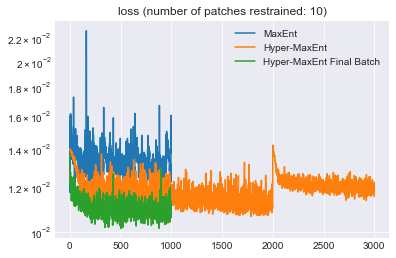

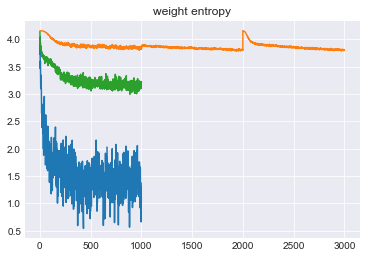

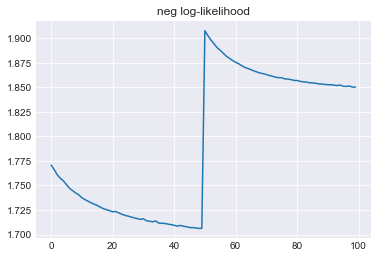

In [21]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

# plt.plot(hme_history.history['loss-from-ref'])
# plt.show()

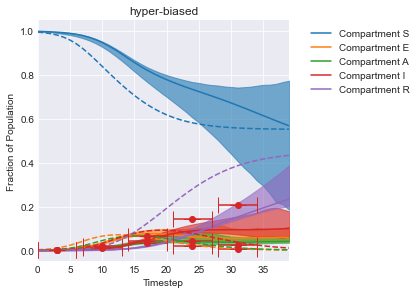

In [22]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('hyper-biased')
plt.show()


## Direct Regression of Model

In [23]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 0.01
infect = maxentep.ContactInfectionLayer(hyper_pram.beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, Mobility_martix_norm, T, infect, Time, agreement)

In [24]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()

150/150 [==============================] - 7s 44ms/step - loss: 0.4644 - output_2_loss: 0.4644


## Visualizing results

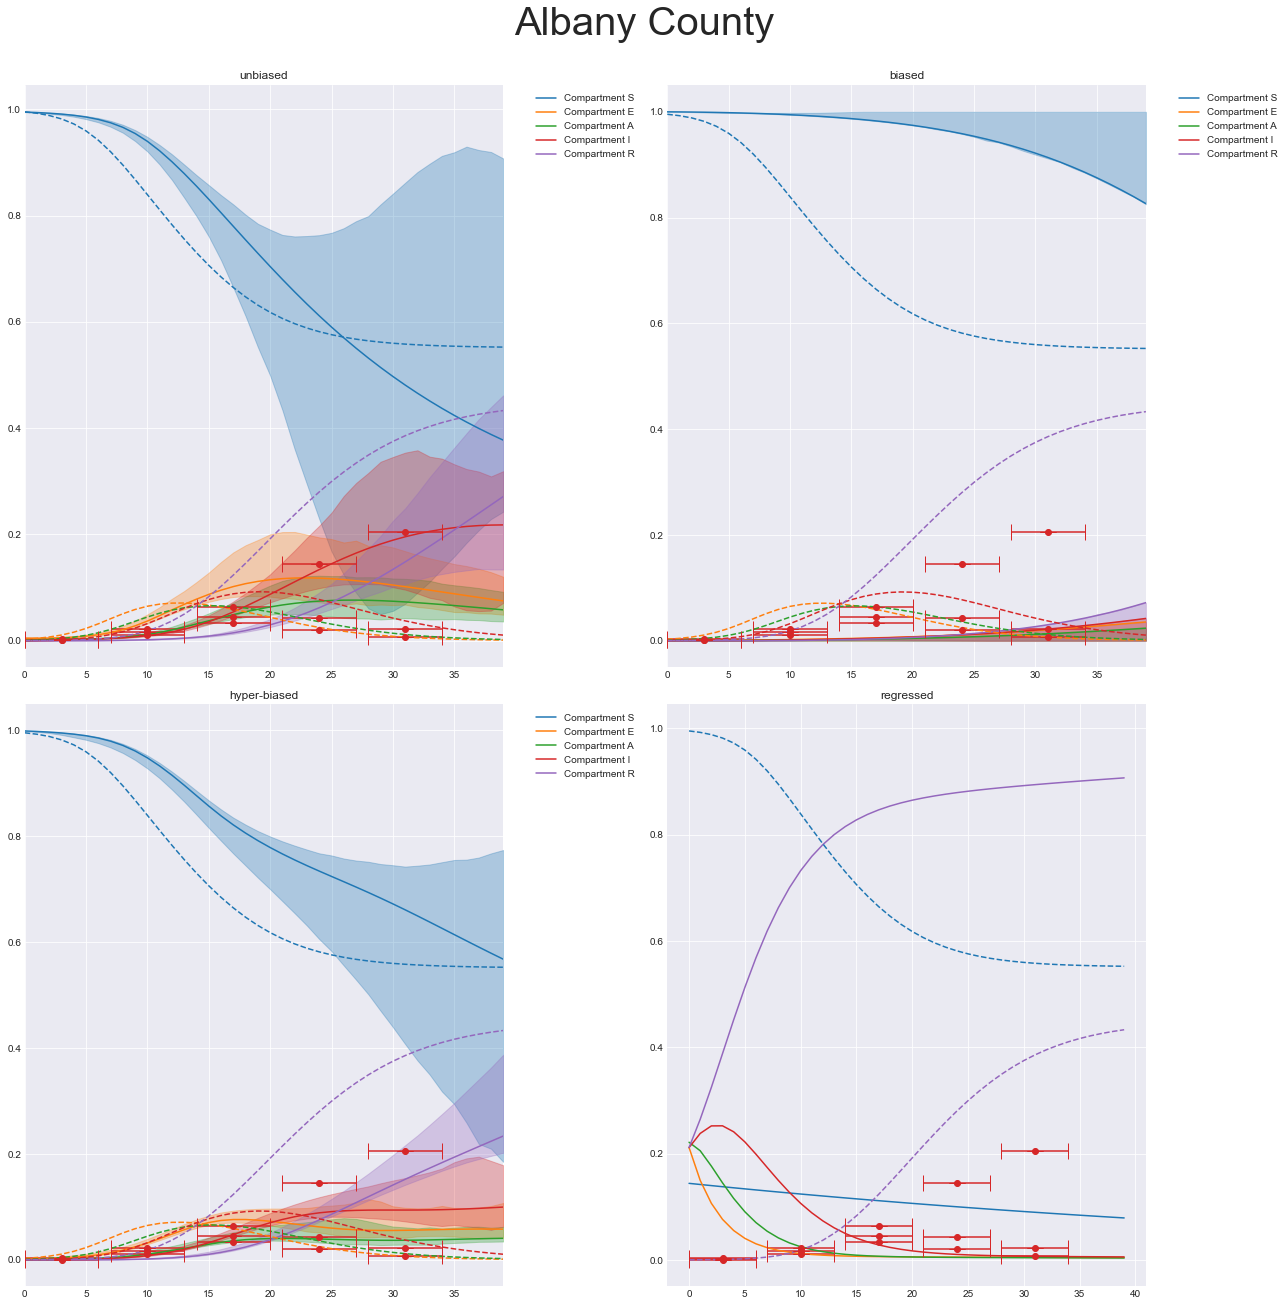

In [25]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')

for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments,alpha = 0.3, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], alpha = 0.3,weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

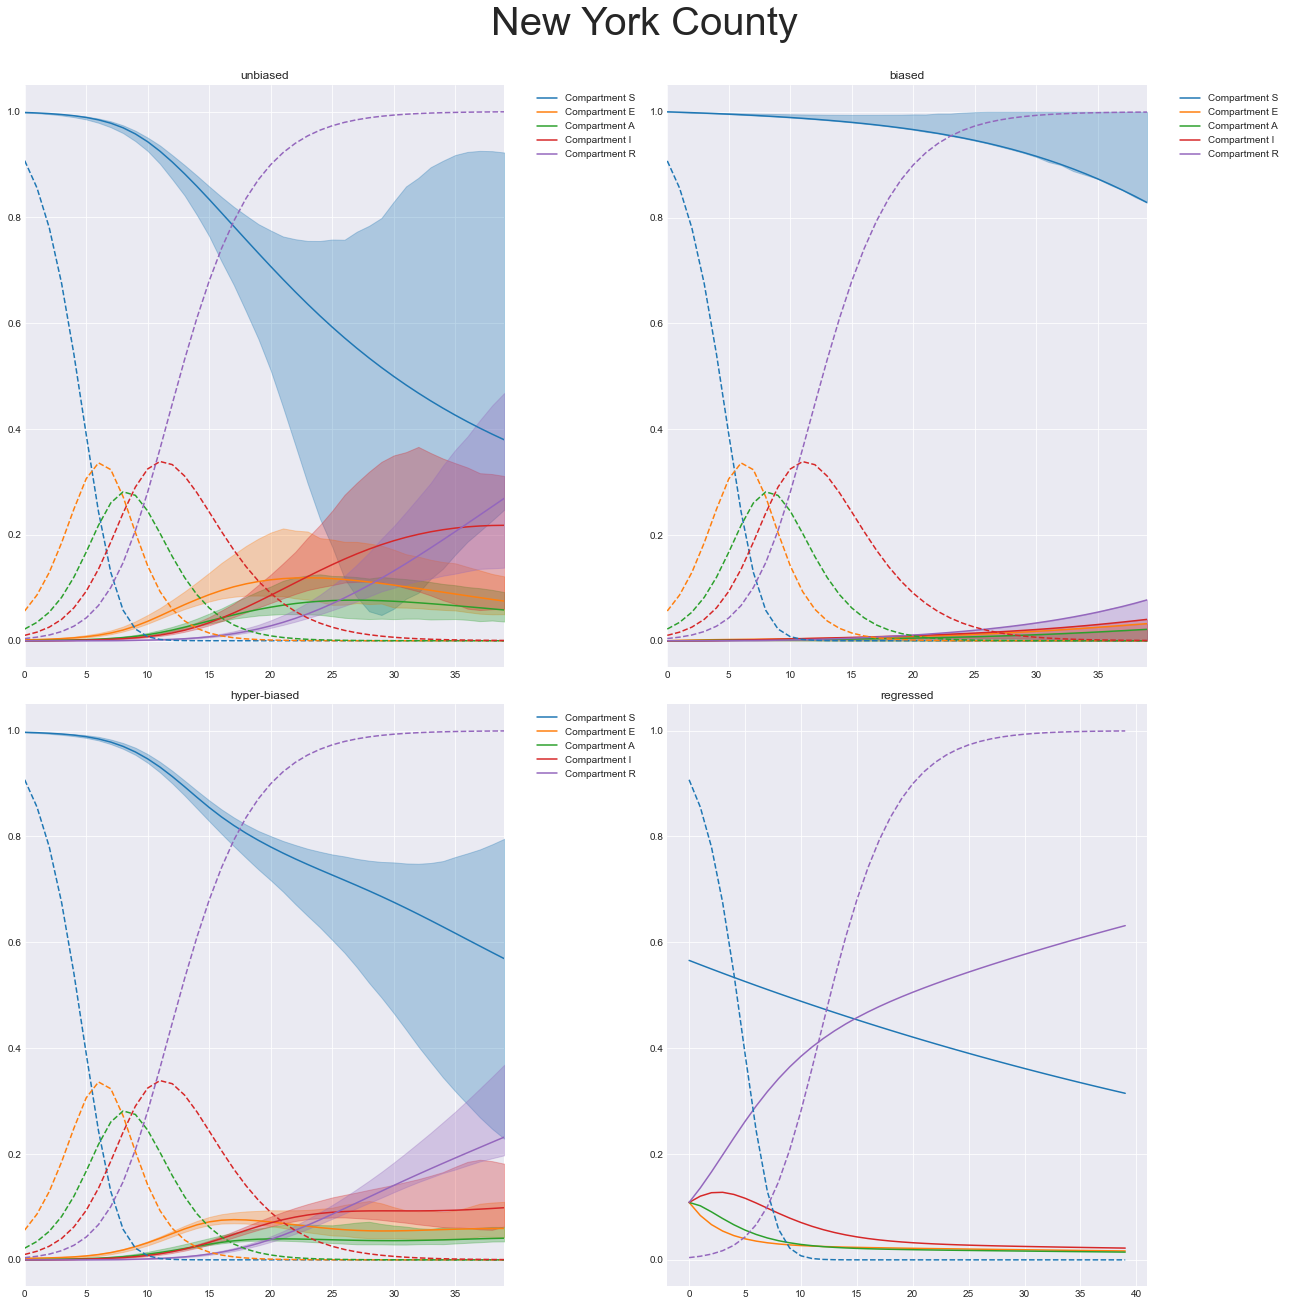

In [26]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# ax[0,0].tick_params(color='green', labelcolor='green')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,0], hme_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

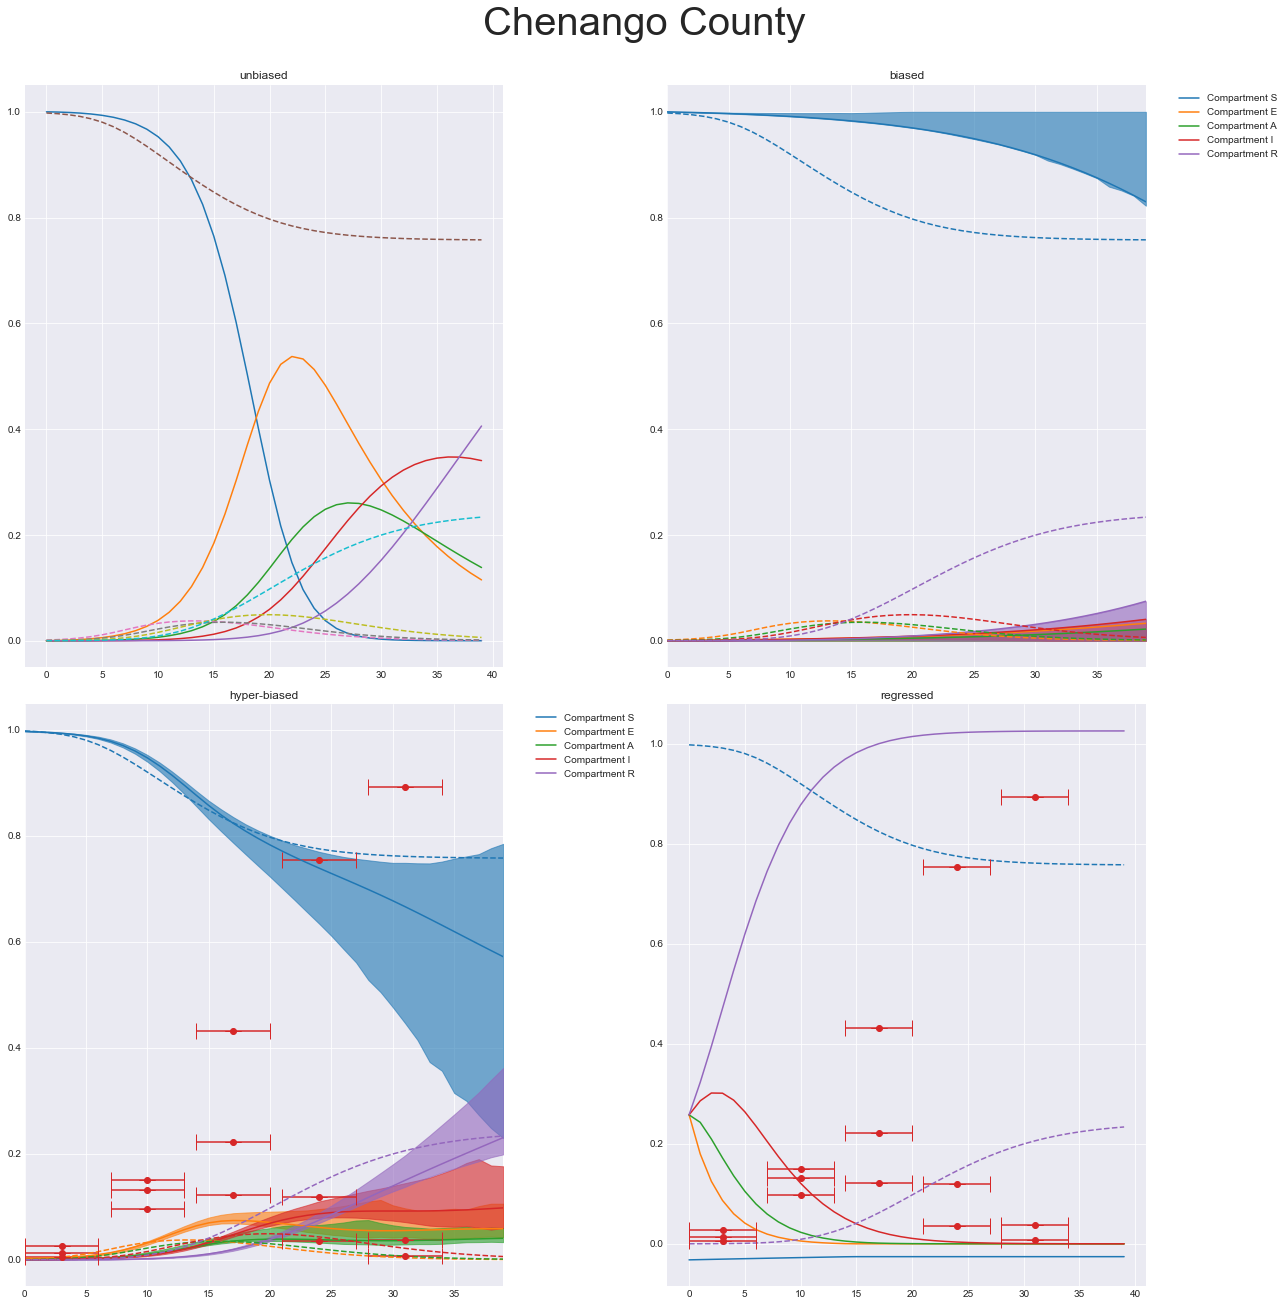

(1, 40, 62, 5)


In [27]:
patch_number = 8
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
axs[0,0].plot(trajs[0,:,patch_number,:])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
print (ref_traj.shape)

In [28]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights, 'hyper-biased':hme_model.traj_weights, 'regression':None }
from matplotlib.patches import Patch
print (restrained_patches)
def compare_patches(ref_traj,trajs,weights_dict, method ,*args, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.005)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


[32 16 22 14  3 47 38 46 43 52]


<class 'numpy.ndarray'>
Plotting 62 patches in a 7 x 9 grid


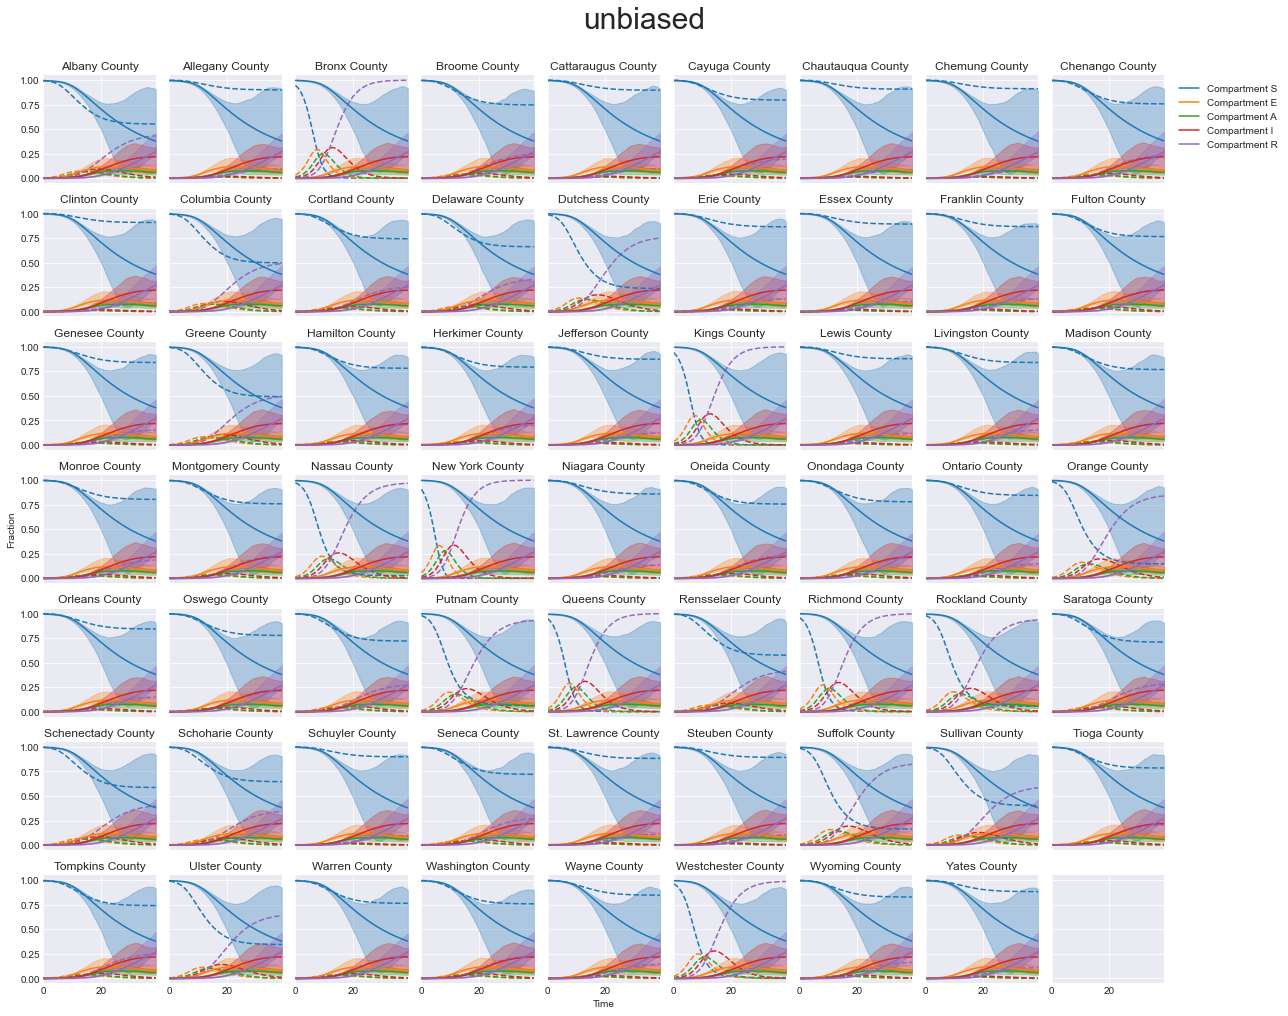

In [29]:
print (type(restrained_patches))
compare_patches(ref_traj,trajs,weights_dict,'unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_unbiased.png',dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

<class 'numpy.ndarray'>
Plotting 62 patches in a 7 x 9 grid


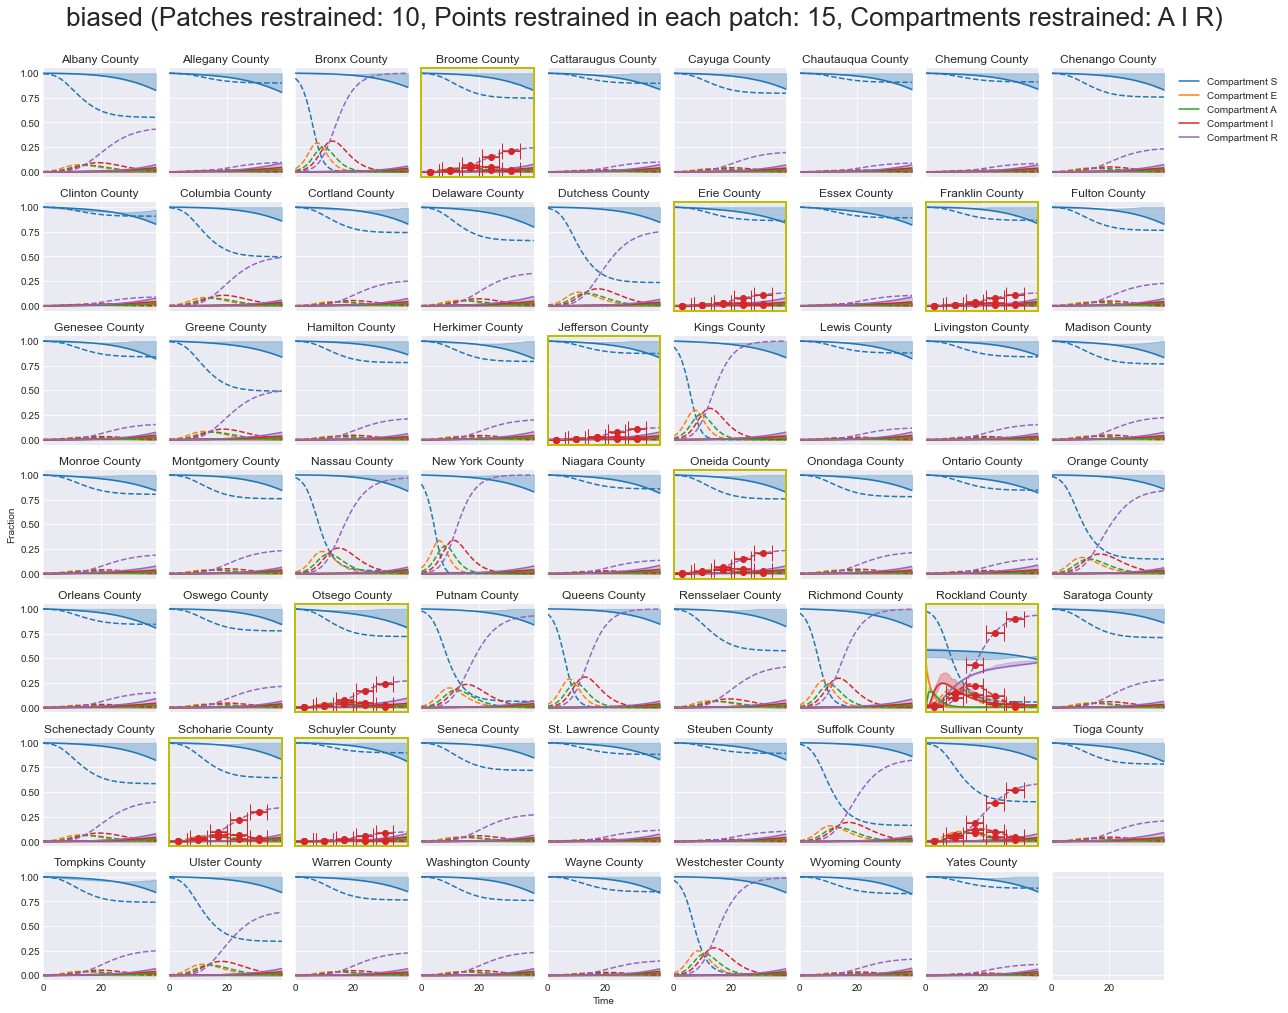

In [30]:
print (type(restrained_patches))
compare_patches(ref_traj,trajs,weights_dict,'biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_biased_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


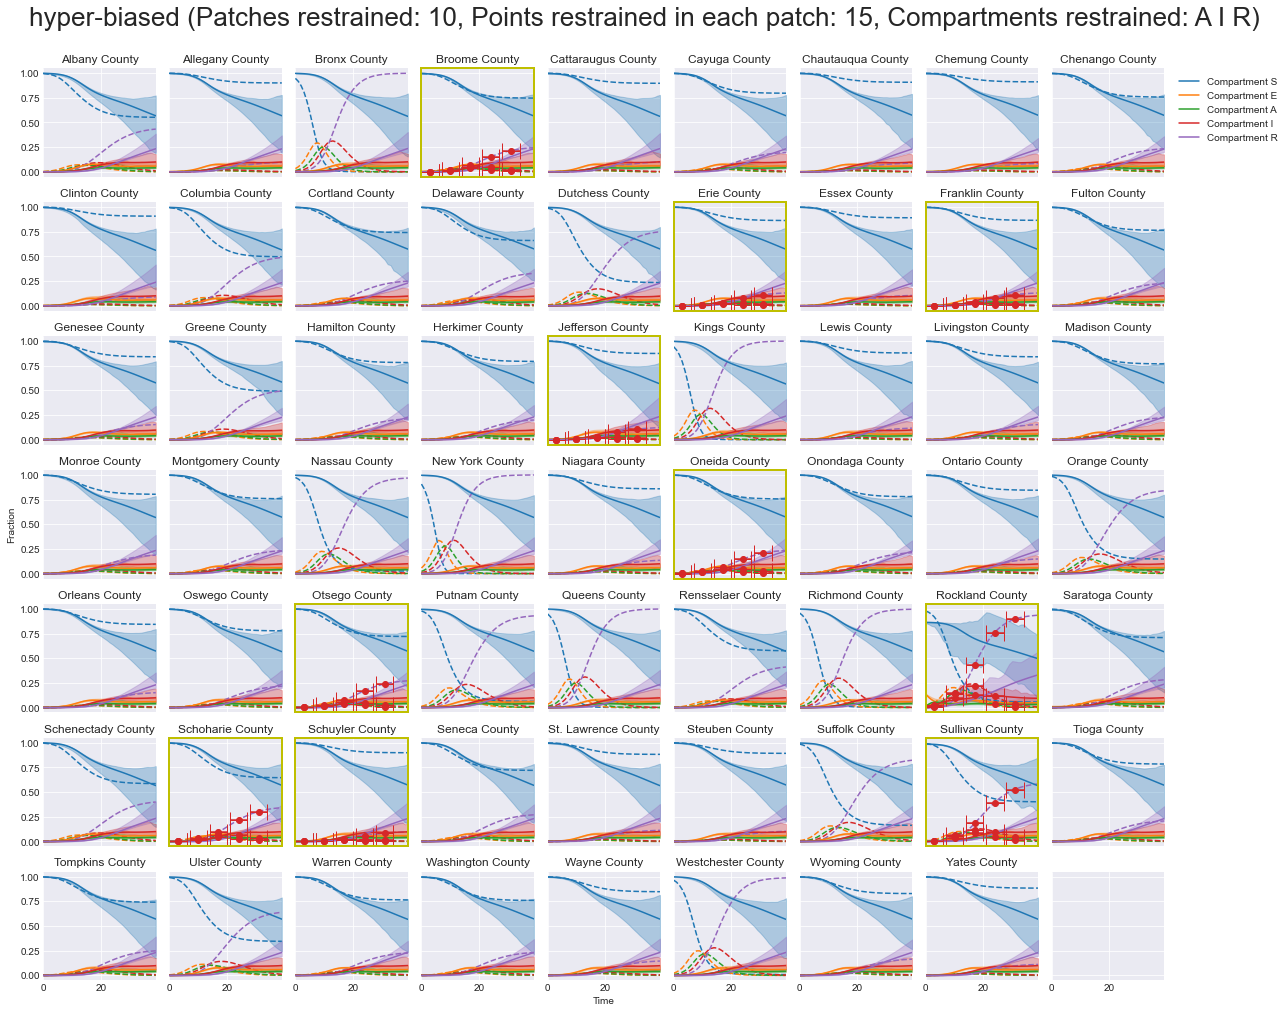

In [31]:
compare_patches(ref_traj,hme_model.trajs,weights_dict,'hyper-biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_hyper_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)

In [32]:
weight_hyper = weights_dict['hyper-biased']
# weight_hyper /=np.sum(weight_hyper)
# mtrajs_patch = np.sum(trajs[:,:,0,:] * weight_hyper[:, np.newaxis, np.newaxis], axis=0)
# print (trajs.shape)
# print (mtrajs_patch.shape)
# print (trajs.shape[2], trajs.shape[-1])
def mean_traj(trajs,weights=None):
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    M = trajs.shape[2]
    if weights is None:
        w = np.ones(trajs.shape[0])
    else:
        w = weights
    w /= np.sum(w)
    mtrajs_counties = np.empty([Time,M,c])
    for i in range(M):
        mtrajs_counties[:,i,:] = np.sum(trajs[:,:,i,:] * w[:, np.newaxis, np.newaxis], axis=0)
    mtrajs = np.sum(mtrajs_counties*population_fraction[np.newaxis, :, np.newaxis],axis=1)
    return mtrajs

    
mtrajs_hyper_biased = mean_traj(hme_model.trajs,weights = weights_dict['hyper-biased'])



mtrajs_biased = mean_traj(trajs,weights = weights_dict['biased'])
mtrajs_unbiased = mean_traj(trajs)
# REF = ref_traj[p,:,:,:]
# REF = np.expand_dims(REF,axis=0)
mref_traj = mean_traj(ref_traj)


mref_traj = mref_traj[:,:5]

loss_unbiased = np.mean((mref_traj- mtrajs_unbiased)**2)
loss_biased = np.mean((mref_traj- mtrajs_biased)**2)
loss_hyper_biased = np.mean((mref_traj- mtrajs_hyper_biased)**2)



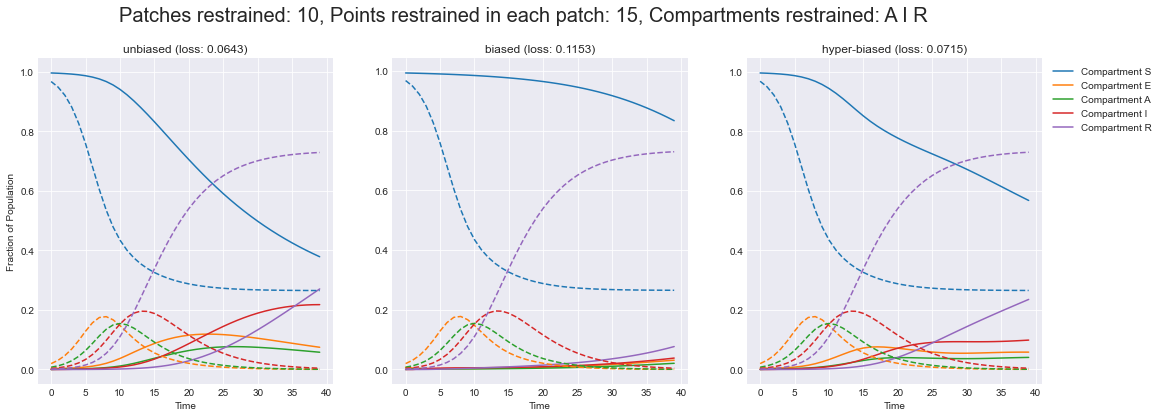

0.9999998565760071


In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {}'
             .format(len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names), fontsize=20,y=1.00)

axs[0].set_title('unbiased (loss: {})'.format(np.round(loss_unbiased,4)))
axs[1].set_title('biased (loss: {})'.format(np.round(loss_biased,4)))
axs[2].set_title('hyper-biased (loss: {})'.format(np.round(loss_hyper_biased,4)))
for i in range(mref_traj.shape[-1]):
    axs[0].plot(range(Time),mtrajs_unbiased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[1].plot(range(Time),mtrajs_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[2].plot(range(Time),mtrajs_hyper_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')

axs[0].plot(mref_traj,linestyle='--')
axs[1].plot(mref_traj,linestyle='--')
axs[2].plot(mref_traj,linestyle='--')
axs[2].legend(bbox_to_anchor=(1.4, 1))
plt.setp(axs[:], xlabel='Time')
plt.setp(axs[0], ylabel='Fraction of Population')

# plt.tight_layout()
plt.savefig('compare_means_restraints_{}{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
plt.show()
print (np.sum(mtrajs_biased[-1]))

In [34]:
Loss = np.mean((mref_traj- mtrajs_unbiased)**2)
print (Loss)
end = time.time()
# print(end - start)

0.06429248610188949


Plotting 62 patches in a 7 x 9 grid


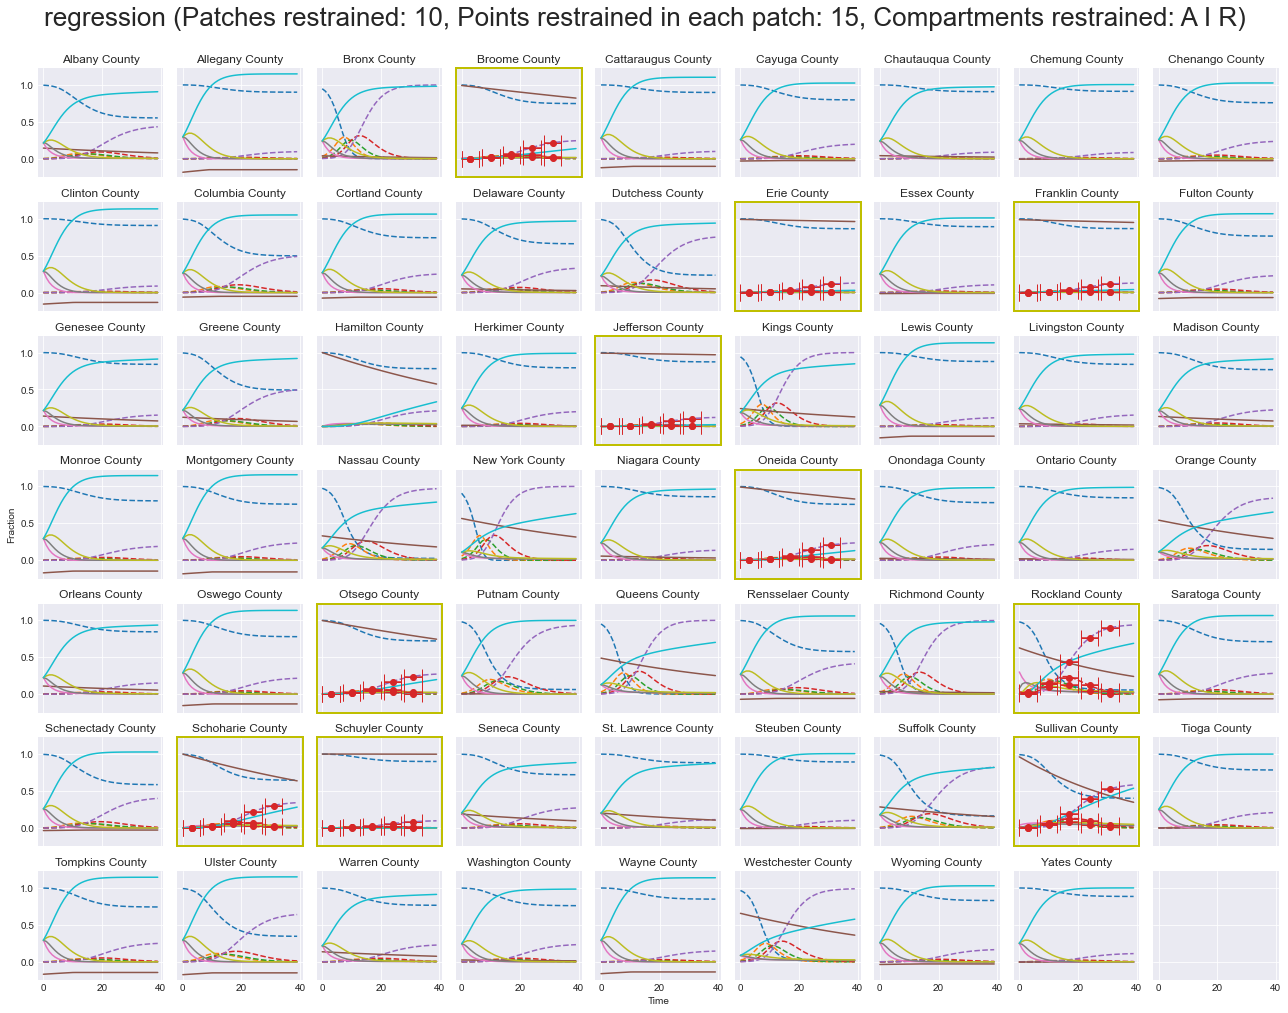

In [35]:
compare_patches(ref_traj,trajs,weights_dict,'regression', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_regression.png',dpi=300)